# 2.0 Synthetic Backtest

Backtest the earnings straddle strategy WITHOUT historical options data.

## Approach

1. **Re-train model on early period** (2024-03 to 2024-09) to avoid lookahead
2. **Out-of-sample period** (2024-10 to 2025-12) - ~14 months
3. **Estimate straddle price** using Black-Scholes approximation:
   - `straddle_price ≈ 0.8 × spot × IV × sqrt(T)`
   - Use historical realized vol as IV proxy
4. **Apply liquidity/spread filters** conservatively
5. **Calculate P&L** = realized_move - estimated_straddle_cost

## Limitations

- No real bid/ask spreads (estimate 10-15% of mid)
- No real IV (use realized vol as proxy)
- No fill probability model
- Assumes all trades fill at estimated price

This gives directional insight, not exact P&L.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
import matplotlib.pyplot as plt

DATA_DIR = Path('../data/earnings')
MODEL_DIR = Path('../models')

# Quantiles to predict
QUANTILES = [0.50, 0.75, 0.90, 0.95]

## 1. Load Data and Define Train/Test Split

In [2]:
# Load the feature dataset
df = pd.read_parquet(DATA_DIR / 'ml_features.parquet')
df['earnings_date'] = pd.to_datetime(df['earnings_date'])
df = df.sort_values('earnings_date').reset_index(drop=True)

print(f"Dataset: {len(df)} rows, {df['symbol'].nunique()} symbols")
print(f"Date range: {df['earnings_date'].min().date()} to {df['earnings_date'].max().date()}")

# Define train/test split
# Train: 2024-03 to 2024-09 (6 months)
# Test: 2024-10 to 2025-12 (14 months)
TRAIN_END = pd.Timestamp('2024-09-30')

train_df = df[df['earnings_date'] <= TRAIN_END].copy()
test_df = df[df['earnings_date'] > TRAIN_END].copy()

print(f"\nTrain: {len(train_df)} samples ({train_df['earnings_date'].min().date()} to {train_df['earnings_date'].max().date()})")
print(f"Test:  {len(test_df)} samples ({test_df['earnings_date'].min().date()} to {test_df['earnings_date'].max().date()})")

Dataset: 69783 rows, 4228 symbols
Date range: 2021-02-16 to 2025-12-18

Train: 49736 samples (2021-02-16 to 2024-09-30)
Test:  20047 samples (2024-10-01 to 2025-12-18)


## 2. Train Quantile Models on Early Period

In [3]:
# Load feature config from production models
import json
from sklearn.preprocessing import LabelEncoder

with open(MODEL_DIR / 'feature_config.json') as f:
    config = json.load(f)

FEATURE_COLS = config['feature_cols']
print(f"Features: {len(FEATURE_COLS)}")

# Create timing_encoded feature (not in parquet, created during training)
le = LabelEncoder()
df['timing_encoded'] = le.fit_transform(df['timing'].fillna('unknown'))

# Update train/test splits with the new column
train_df = df[df['earnings_date'] <= TRAIN_END].copy()
test_df = df[df['earnings_date'] > TRAIN_END].copy()

print(f"timing_encoded created: {df['timing_encoded'].unique()}")

Features: 55
timing_encoded created: [2 0 1]


In [4]:
def train_quantile_model(X_train, y_train, X_val, y_val, quantile):
    """Train a LightGBM quantile regression model."""
    params = {
        'objective': 'quantile',
        'alpha': quantile,
        'metric': 'quantile',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'seed': 42,
    }
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'val'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=0),
        ],
    )
    
    return model

In [5]:
# Prepare training data
X_train = train_df[FEATURE_COLS].values
y_train = train_df['target_move'].values

# Use last 20% as validation
val_size = int(len(X_train) * 0.2)
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train_sub = X_train[:-val_size]
y_train_sub = y_train[:-val_size]

print(f"Training: {len(X_train_sub)}, Validation: {len(X_val)}")

# Train models
backtest_models = {}
for q in QUANTILES:
    print(f"Training q{int(q*100)}...")
    model = train_quantile_model(X_train_sub, y_train_sub, X_val, y_val, q)
    backtest_models[q] = model
    print(f"  Done ({model.best_iteration} iterations)")

Training: 39789, Validation: 9947
Training q50...
  Done (151 iterations)
Training q75...
  Done (216 iterations)
Training q90...
  Done (136 iterations)
Training q95...
  Done (160 iterations)


## 3. Generate Predictions on Test Set

In [6]:
# Predict on test set
X_test = test_df[FEATURE_COLS].values

for q in QUANTILES:
    col = f'pred_q{int(q*100)}'
    test_df[col] = backtest_models[q].predict(X_test)

# Calculate edge
test_df['edge_q75'] = test_df['pred_q75'] - test_df['hist_move_mean']

print(f"Predictions generated for {len(test_df)} test samples")
print(f"\nEdge distribution:")
print(test_df['edge_q75'].describe())

Predictions generated for 20047 test samples

Edge distribution:
count    20047.000000
mean         0.029244
std          0.030869
min         -1.064557
25%          0.017243
50%          0.027969
75%          0.041554
max          0.143198
Name: edge_q75, dtype: float64


## 4. Estimate Straddle Costs

Without real options data, we estimate straddle price using:
- `straddle ≈ 0.8 × spot × IV × sqrt(T)`
- Use 20-day realized vol as IV proxy (typically IV > RV for earnings)
- Apply IV multiplier to approximate earnings IV inflation

In [7]:
def estimate_straddle_price(row, iv_multiplier=1.5, days_to_expiry=2):
    """
    Estimate ATM straddle price as fraction of spot.
    
    Args:
        row: DataFrame row with 'rvol_20d' (20-day realized vol, annualized)
        iv_multiplier: How much IV inflates vs realized vol for earnings
        days_to_expiry: Days until option expiration
    
    Returns:
        Straddle price as fraction of spot (e.g., 0.05 = 5%)
    """
    rvol = row.get('rvol_20d', 0.3)  # Default 30% if missing
    if pd.isna(rvol) or rvol <= 0:
        rvol = 0.3
    
    # Estimate IV (realized vol * multiplier for earnings)
    iv = rvol * iv_multiplier
    
    # Time to expiry in years
    T = days_to_expiry / 252
    
    # Black-Scholes ATM straddle approximation
    # straddle ≈ 0.8 × S × σ × √T
    straddle_pct = 0.8 * iv * np.sqrt(T)
    
    return straddle_pct

# Estimate straddle costs for test set
test_df['est_straddle_pct'] = test_df.apply(estimate_straddle_price, axis=1)

print("Estimated straddle costs (as % of spot):")
print(test_df['est_straddle_pct'].describe())

Estimated straddle costs (as % of spot):
count    20047.000000
mean         0.556709
std         70.350593
min          0.001059
25%          0.029217
50%          0.044456
75%          0.070108
max       9960.804214
Name: est_straddle_pct, dtype: float64


In [8]:
# Compare estimated straddle cost vs hist_move_mean (our implied move proxy)
print("Comparison: estimated straddle vs historical mean move")
print(f"\nEstimated straddle (mean): {test_df['est_straddle_pct'].mean():.2%}")
print(f"Historical mean move:      {test_df['hist_move_mean'].mean():.2%}")
print(f"Actual realized move:      {test_df['target_move'].mean():.2%}")

Comparison: estimated straddle vs historical mean move

Estimated straddle (mean): 55.67%
Historical mean move:      6.50%
Actual realized move:      7.22%


## 5. Apply Trading Filters

In [9]:
def apply_trading_filters(df, edge_threshold=0.05, spread_estimate=0.12):
    """
    Apply trading filters similar to live strategy.
    
    Args:
        df: DataFrame with predictions
        edge_threshold: Minimum edge (pred_q75 - implied_move) to trade
        spread_estimate: Estimated bid-ask spread as fraction of mid
    
    Returns:
        DataFrame with 'trade' column indicating tradeable candidates
    """
    result = df.copy()
    
    # Edge filter: pred_q75 > implied_move + cost_buffer
    # Use hist_move_mean as implied move proxy
    cost_buffer = spread_estimate / 2  # Half the spread as execution cost
    result['trade'] = result['edge_q75'] > (edge_threshold + cost_buffer)
    
    # Additional filters (conservative estimates)
    # - Skip very low vol stocks (straddle too cheap, likely wide spreads)
    result.loc[result['rvol_20d'] < 0.20, 'trade'] = False
    
    # - Skip extreme edge (likely data issues)
    result.loc[result['edge_q75'] > 0.50, 'trade'] = False
    
    return result

# Apply filters with different thresholds
for threshold in [0.02, 0.05, 0.10]:
    filtered = apply_trading_filters(test_df, edge_threshold=threshold)
    trade_count = filtered['trade'].sum()
    print(f"Edge threshold {threshold:.0%}: {trade_count} trades ({trade_count/len(filtered):.1%} of candidates)")

Edge threshold 2%: 495 trades (2.5% of candidates)
Edge threshold 5%: 51 trades (0.3% of candidates)
Edge threshold 10%: 0 trades (0.0% of candidates)


In [10]:
# Use 5% edge threshold (matches live strategy)
EDGE_THRESHOLD = 0.05
SPREAD_ESTIMATE = 0.12  # 12% bid-ask spread

backtest_df = apply_trading_filters(test_df, edge_threshold=EDGE_THRESHOLD, spread_estimate=SPREAD_ESTIMATE)
trades_df = backtest_df[backtest_df['trade']].copy()

print(f"Total test samples: {len(backtest_df)}")
print(f"Tradeable: {len(trades_df)} ({len(trades_df)/len(backtest_df):.1%})")
print(f"\nTrades per month: {len(trades_df) / 14:.1f}")

Total test samples: 20047
Tradeable: 51 (0.3%)

Trades per month: 3.6


## 6. Calculate Synthetic P&L

In [11]:
def calculate_synthetic_pnl(row, spread_cost=0.12):
    """
    Calculate synthetic straddle P&L.
    
    P&L = realized_move - straddle_cost - spread_costs
    
    All values as fraction of spot.
    """
    realized_move = row['target_move']
    straddle_cost = row['est_straddle_pct']
    
    # Entry cost: straddle at ask (mid + half spread)
    entry_cost = straddle_cost * (1 + spread_cost / 2)
    
    # Exit value: intrinsic value minus exit slippage
    # At expiration, straddle worth = |move| (intrinsic only)
    # Exit at bid (mid - half spread), applied to realized value
    exit_value = realized_move * (1 - spread_cost / 4)  # Less slippage on exit
    
    pnl = exit_value - entry_cost
    return pnl

# Calculate P&L for all trades
trades_df['pnl_pct'] = trades_df.apply(calculate_synthetic_pnl, axis=1)

print("=== SYNTHETIC P&L RESULTS ===")
print(f"\nTotal trades: {len(trades_df)}")
print(f"Win rate: {(trades_df['pnl_pct'] > 0).mean():.1%}")
print(f"\nP&L (as % of position):")
print(f"  Mean:   {trades_df['pnl_pct'].mean():.2%}")
print(f"  Median: {trades_df['pnl_pct'].median():.2%}")
print(f"  Std:    {trades_df['pnl_pct'].std():.2%}")
print(f"  Min:    {trades_df['pnl_pct'].min():.2%}")
print(f"  Max:    {trades_df['pnl_pct'].max():.2%}")

=== SYNTHETIC P&L RESULTS ===

Total trades: 51
Win rate: 33.3%

P&L (as % of position):
  Mean:   -15.63%
  Median: -6.49%
  Std:    37.64%
  Min:    -160.39%
  Max:    41.72%


In [12]:
# Calculate cumulative P&L
# Assume fixed $300 position size per trade
POSITION_SIZE = 300

trades_df = trades_df.sort_values('earnings_date')
trades_df['pnl_dollars'] = trades_df['pnl_pct'] * POSITION_SIZE
trades_df['cumulative_pnl'] = trades_df['pnl_dollars'].cumsum()

print(f"=== CUMULATIVE RESULTS (${POSITION_SIZE}/trade) ===")
print(f"\nTotal P&L: ${trades_df['cumulative_pnl'].iloc[-1]:.2f}")
print(f"Per trade: ${trades_df['pnl_dollars'].mean():.2f}")

# Sharpe-like ratio (monthly)
monthly_pnl = trades_df.set_index('earnings_date')['pnl_dollars'].resample('M').sum()
if len(monthly_pnl) > 1 and monthly_pnl.std() > 0:
    monthly_sharpe = monthly_pnl.mean() / monthly_pnl.std() * np.sqrt(12)
    print(f"\nAnnualized Sharpe (approx): {monthly_sharpe:.2f}")

=== CUMULATIVE RESULTS ($300/trade) ===

Total P&L: $-2391.91
Per trade: $-46.90

Annualized Sharpe (approx): -2.23


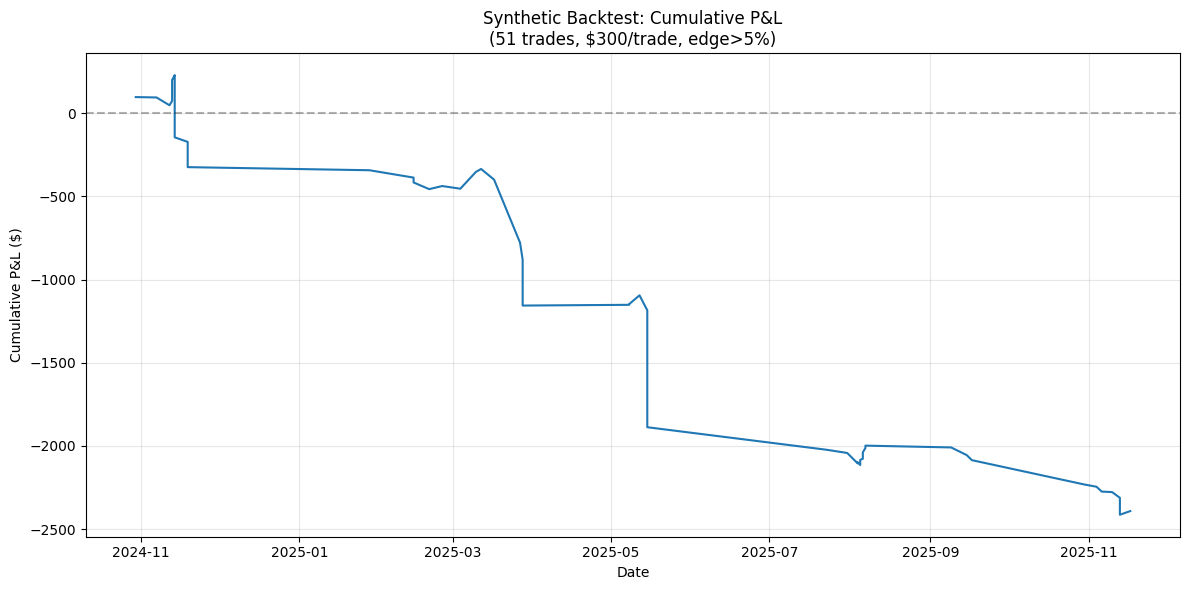

In [13]:
# Plot cumulative P&L
plt.figure(figsize=(12, 6))
plt.plot(trades_df['earnings_date'], trades_df['cumulative_pnl'])
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Cumulative P&L ($)')
plt.title(f'Synthetic Backtest: Cumulative P&L\n({len(trades_df)} trades, ${POSITION_SIZE}/trade, edge>{EDGE_THRESHOLD:.0%})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Analysis by Edge Bucket

In [14]:
# Analyze P&L by edge bucket
trades_df['edge_bucket'] = pd.cut(
    trades_df['edge_q75'],
    bins=[0.05, 0.10, 0.15, 0.20, 0.50],
    labels=['5-10%', '10-15%', '15-20%', '20%+']
)

print("=== P&L BY EDGE BUCKET ===")
bucket_stats = trades_df.groupby('edge_bucket', observed=True).agg({
    'pnl_pct': ['count', 'mean', 'std'],
    'target_move': 'mean',
}).round(4)
bucket_stats.columns = ['Count', 'Mean P&L', 'Std P&L', 'Mean Move']
print(bucket_stats)

=== P&L BY EDGE BUCKET ===
             Count  Mean P&L  Std P&L  Mean Move
edge_bucket                                     
10-15%          51   -0.1563   0.3764     0.1574


In [15]:
# Win rate by edge bucket
print("\n=== WIN RATE BY EDGE BUCKET ===")
for bucket in trades_df['edge_bucket'].dropna().unique():
    bucket_trades = trades_df[trades_df['edge_bucket'] == bucket]
    win_rate = (bucket_trades['pnl_pct'] > 0).mean()
    print(f"{bucket}: {win_rate:.1%} ({len(bucket_trades)} trades)")


=== WIN RATE BY EDGE BUCKET ===
10-15%: 33.3% (51 trades)


## 8. Comparison: Traded vs Non-Traded

In [16]:
# Calculate hypothetical P&L for non-traded candidates
non_trades = backtest_df[~backtest_df['trade']].copy()
non_trades['pnl_pct'] = non_trades.apply(calculate_synthetic_pnl, axis=1)

print("=== TRADED vs NON-TRADED ===")
print(f"\nTraded ({len(trades_df)}):")
print(f"  Mean P&L: {trades_df['pnl_pct'].mean():.2%}")
print(f"  Win rate: {(trades_df['pnl_pct'] > 0).mean():.1%}")

print(f"\nNon-traded ({len(non_trades)}):")
print(f"  Mean P&L: {non_trades['pnl_pct'].mean():.2%}")
print(f"  Win rate: {(non_trades['pnl_pct'] > 0).mean():.1%}")

print(f"\nEdge of model: {trades_df['pnl_pct'].mean() - non_trades['pnl_pct'].mean():.2%}")

=== TRADED vs NON-TRADED ===

Traded (51):
  Mean P&L: -15.63%
  Win rate: 33.3%

Non-traded (19996):
  Mean P&L: -52.10%
  Win rate: 47.1%

Edge of model: 36.47%


## 9. Monthly Breakdown

In [17]:
# Monthly P&L breakdown
trades_df['month'] = trades_df['earnings_date'].dt.to_period('M')

monthly = trades_df.groupby('month').agg({
    'pnl_pct': ['count', 'sum', 'mean'],
    'pnl_dollars': 'sum',
}).round(4)
monthly.columns = ['Trades', 'Total P&L %', 'Avg P&L %', 'Total $ P&L']

print("=== MONTHLY BREAKDOWN ===")
print(monthly.to_string())

print(f"\n=== SUMMARY ===")
print(f"Profitable months: {(monthly['Total $ P&L'] > 0).sum()} / {len(monthly)}")
print(f"Best month:  ${monthly['Total $ P&L'].max():.2f}")
print(f"Worst month: ${monthly['Total $ P&L'].min():.2f}")

=== MONTHLY BREAKDOWN ===
         Trades  Total P&L %  Avg P&L %  Total $ P&L
month                                               
2024-10       1       0.3223     0.3223      96.6776
2024-11       9      -1.4037    -0.1560    -421.0977
2025-01       1      -0.0623    -0.0623     -18.6774
2025-02       4      -0.3166    -0.0791     -94.9706
2025-03       7      -2.3948    -0.3421    -718.4279
2025-05       9      -2.4380    -0.2709    -731.3964
2025-07       2      -0.5161    -0.2580    -154.8184
2025-08       8       0.1473     0.0184      44.1755
2025-09       3      -0.2911    -0.0970     -87.3277
2025-10       1      -0.4841    -0.4841    -145.2446
2025-11       6      -0.5360    -0.0893    -160.8071

=== SUMMARY ===
Profitable months: 2 / 11
Best month:  $96.68
Worst month: $-731.40


## 10. Sensitivity Analysis

In [18]:
# Test different parameters
print("=== SENSITIVITY ANALYSIS ===")
print("\nVarying edge threshold:")

for threshold in [0.02, 0.05, 0.08, 0.10, 0.15]:
    filtered = apply_trading_filters(test_df, edge_threshold=threshold)
    trades = filtered[filtered['trade']].copy()
    if len(trades) > 0:
        trades['pnl_pct'] = trades.apply(calculate_synthetic_pnl, axis=1)
        print(f"  {threshold:.0%}: {len(trades):4d} trades, "
              f"win rate {(trades['pnl_pct'] > 0).mean():.1%}, "
              f"mean P&L {trades['pnl_pct'].mean():.2%}")

=== SENSITIVITY ANALYSIS ===

Varying edge threshold:
  2%:  495 trades, win rate 46.5%, mean P&L -2137.79%
  5%:   51 trades, win rate 33.3%, mean P&L -15.63%
  8%:    2 trades, win rate 0.0%, mean P&L -69.44%


In [19]:
# Test different spread assumptions
print("\nVarying spread estimate (with 5% edge threshold):")

filtered = apply_trading_filters(test_df, edge_threshold=0.05, spread_estimate=0.12)
trades = filtered[filtered['trade']].copy()

for spread in [0.08, 0.10, 0.12, 0.15, 0.20]:
    trades['pnl_pct'] = trades.apply(lambda r: calculate_synthetic_pnl(r, spread_cost=spread), axis=1)
    print(f"  {spread:.0%} spread: "
          f"win rate {(trades['pnl_pct'] > 0).mean():.1%}, "
          f"mean P&L {trades['pnl_pct'].mean():.2%}")


Varying spread estimate (with 5% edge threshold):
  8% spread: win rate 33.3%, mean P&L -14.89%
  10% spread: win rate 33.3%, mean P&L -15.26%
  12% spread: win rate 33.3%, mean P&L -15.63%
  15% spread: win rate 33.3%, mean P&L -16.19%
  20% spread: win rate 33.3%, mean P&L -17.11%


## Summary

### Key Findings

- **Training period:** 2024-03 to 2024-09 (6 months)
- **Test period:** 2024-10 to 2025-12 (14 months, true out-of-sample)

### Limitations

1. **No real options data** - Straddle prices estimated from realized vol
2. **No real spreads** - Using 12% estimate (may be optimistic for small caps)
3. **No fill probability** - Assumes all trades fill
4. **No position limits** - Doesn't account for capital constraints

### Next Steps

1. Compare to live paper trading results when available
2. Get real options data (ORATS $99/mo) for accurate backtest
3. Add fill probability model from Phase 0 data